## Librerías a utilizar
Importamos primero las librerias que utilizaremos

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!kaggle datasets download -d gpiosenka/coffee-bean-dataset-resized-224-x-224
!unzip coffee-bean-dataset-resized-224-x-224.zip
!mkdir ./dataset
!mv ./test ./dataset/test
!mv ./train ./dataset/train

In [2]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import keras
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Rescaling, Dropout, BatchNormalization
from keras.models import Sequential
from keras import layers
import os
import time
import numpy as np


2024-04-06 09:30:06.523378: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 09:30:06.555033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 09:30:06.555080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 09:30:06.555864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 09:30:06.562367: I tensorflow/core/platform/cpu_feature_guar

Revisamos que `tensorflow` esté utilizando los GPUs disponibles

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-06 09:30:09.402555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 09:30:09.487552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 09:30:09.487642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Cargando datasets de entrenamiento y pruebas

Podemos utilizar la función `image_dataset_from_directory` de `tensorflow` para cargar nuestro dataset mas facilmente, ya que este se encuentra en una estructura que puede ser aprovechada por esta función:

* train
  * Dark
  * Green
  * Light
  * Medium
* test
  * Dark
  * Green
  * Light
  * Medium

In [4]:
train_dir = os.path.join('.','dataset','train')
test_dir = os.path.join('.','dataset','test')
random_seed = 123
batch_size = 8

Al importar el set de entrenamiento, reservamos el 20% de nuestros datos para el set de validación.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'int',
    seed = random_seed,
    shuffle = True,
    validation_split = 0.2,
    subset = 'training',
    batch_size = batch_size
)

Found 1200 files belonging to 4 classes.
Using 960 files for training.


2024-04-06 09:30:09.610342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 09:30:09.610430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 09:30:09.610448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 09:30:09.929477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 09:30:09.930197: I external/local_xla/xla/stream_executor

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'int',
    seed = random_seed,
    shuffle = True,
    validation_split = 0.2,
    subset = 'validation',
    batch_size = batch_size
)

Found 1200 files belonging to 4 classes.
Using 240 files for validation.


Ahora que importamos nuestro dataset, revisamos que nuestras clases estén balanceadas, o no muy desbalanceadas.

Primero creamos una función para contar las entradas de cada clase a partir de un objeto tipo `tf.data.Dataset`:

In [7]:
num_classes = 4

@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

train_counts = train_ds.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)

val_counts = val_ds.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)

print(train_counts.numpy(), sum(train_counts.numpy()))
print(val_counts.numpy(), sum(val_counts.numpy()))

[247 223 241 249] 960
[53 77 59 51] 240


Después obtenemos e imprimimos los nombres de cada clase a partir de nuestro dataset:

In [8]:
class_names = train_ds.class_names
print(class_names)

['Dark', 'Green', 'Light', 'Medium']


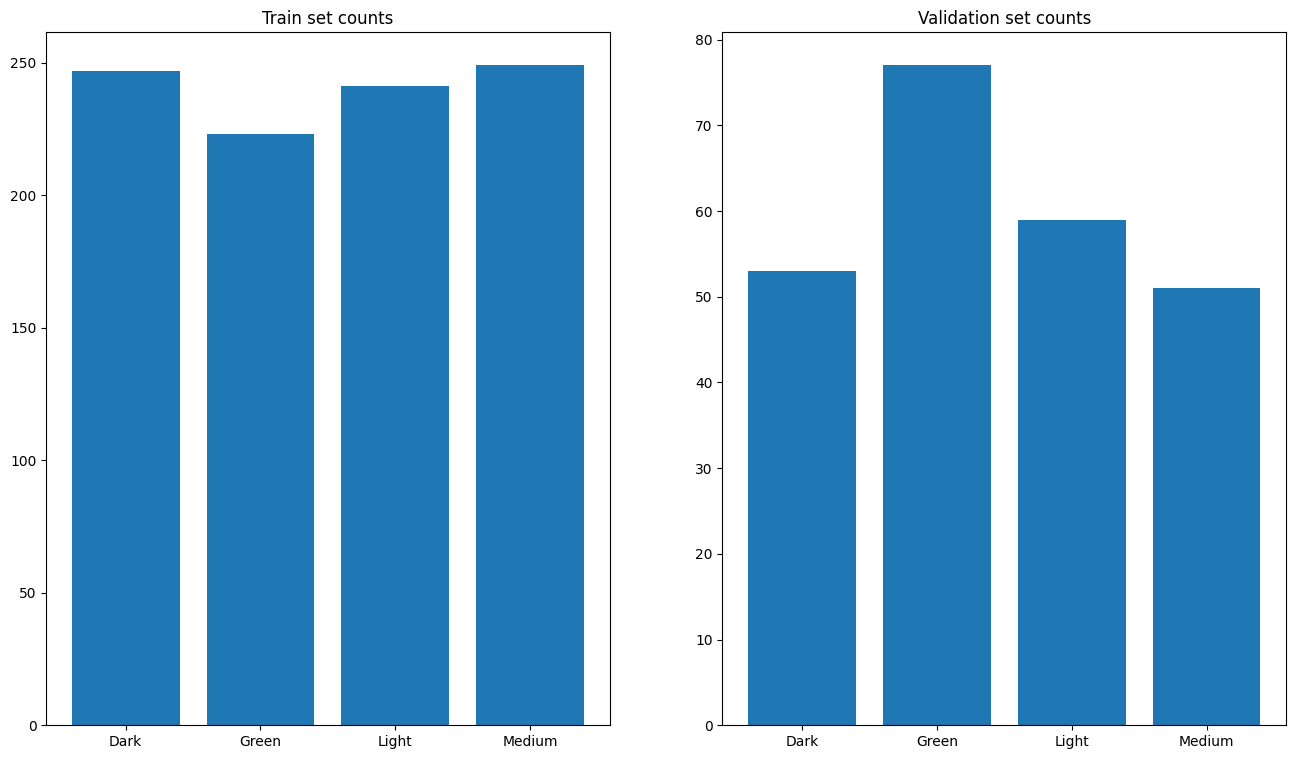

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,9)
ax[0].bar(class_names,train_counts)
ax[0].set_title("Train set counts")
ax[1].bar(class_names, val_counts)
ax[1].set_title("Validation set counts")
plt.show()

Ahora, podemos tratar de visualizar algunas entradas de nuestro dataset, tomando entradas del primer lote (batch)

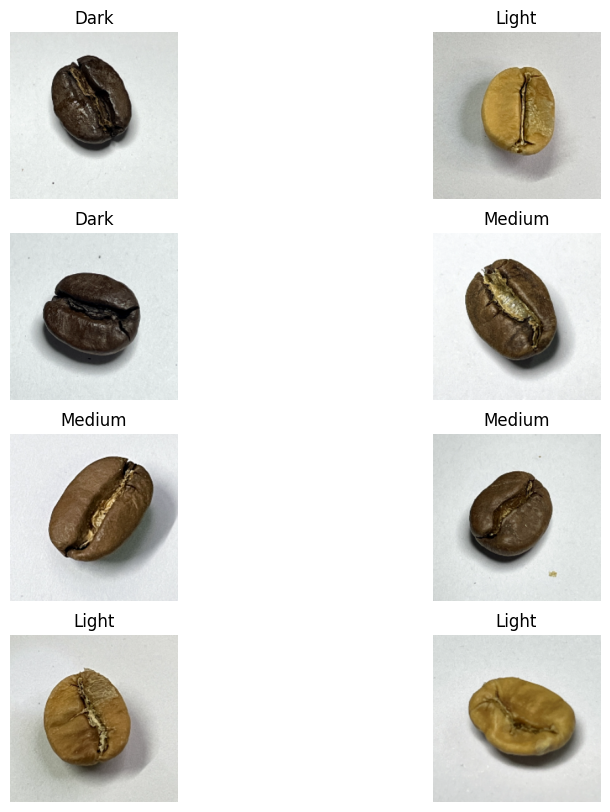

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Podemos imprimir ahora el tamaño de cada batch en nuestro dataset, asi como el tamaño de las imágenes y sus canales. También imprimimos `y` para observar la forma que toma este tensor:

In [11]:
for x, y in train_ds.take(1):
  print(x.shape, y)

(8, 256, 256, 3) tf.Tensor([1 0 3 2 3 1 3 3], shape=(8,), dtype=int32)


Cargamos tambien nuestro dataset de pruebas y realizamos el mismo procedimiento:

In [12]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                    directory= test_dir,
                    labels = 'inferred',
                    label_mode = 'int',
                    seed=random_seed,
                    shuffle=False,
                    batch_size=batch_size
)

Found 400 files belonging to 4 classes.


In [13]:
for x, y in test_ds.take(1):
  print(x.shape, y)

(8, 256, 256, 3) tf.Tensor([0 0 0 0 0 0 0 0], shape=(8,), dtype=int32)


## Construyendo la red

Antes de construir la red, podemos generar un modelo de aumento de datos, para agregarlo después a nuestro modelo final

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256, 256, 3), name = 'random_flip'),
    layers.RandomRotation( 0.1 , name = 'random_rot'),
    layers.RandomZoom( 0.5, name = 'random_zoom' ),
  ]
)

Tomamos una imagen de nuestro dataset para verificar el funcionamiento del modelo de aumento de datos:

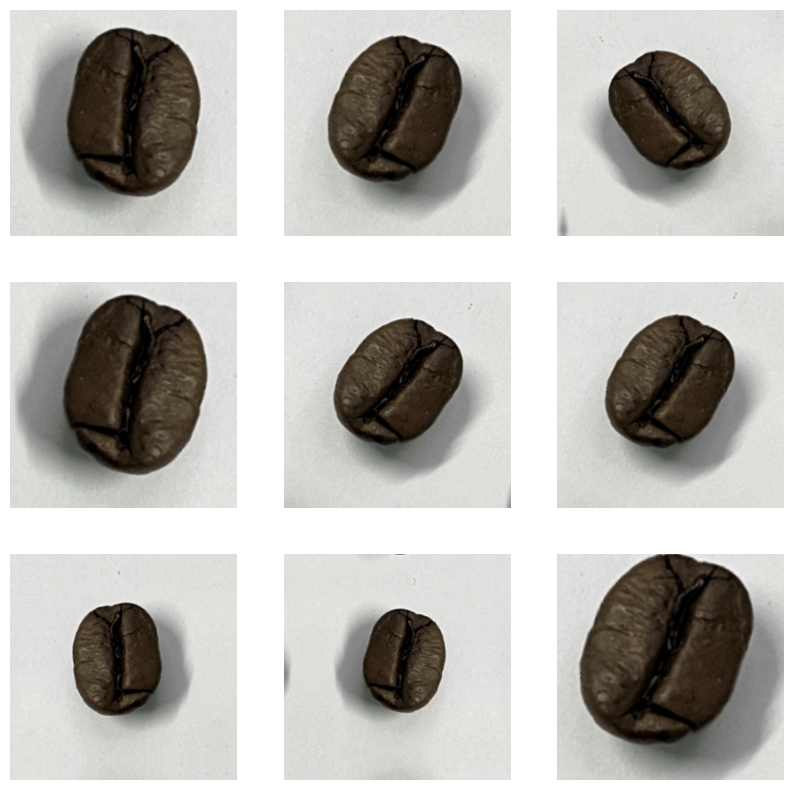

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
      model = Sequential(name = 'coffee_classifier')
      # No utilizamos la capa de data_augmentation porque disminuyó la precision
      model.add(Rescaling(1./255, input_shape=(256,256,3)))

      for i in range(hp.Int("num_layers", 1, 3)):  # Tune the number of layers.
            model.add(
                Conv2D(
                    filters     = hp.Choice(f'filters_{i}', [16,32] ), # Tune number of units separately.
                    kernel_size = hp.Choice(f'kernel_size_{i}', [2, 3]),
                    activation  = 'relu'
                )
            )
            
            model.add(
                MaxPooling2D(
                    pool_size = hp.Choice(f'pool_size_{i}',[2, 3])
                )
            )

      model.add(Dropout(
          rate = hp.Choice('dropout_rate', [0.2, 0.3, 0.4])
              )
          )
      
      model.add(Flatten())

      model.add(Dense(units=128, activation='relu'))
      model.add(BatchNormalization())


      model.add(Dense(4, activation='softmax', name = "prediction"))  # <---- capa de salida (REGRESIÓN)


      lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

      model.compile( 
          optimizer = keras.optimizers.Adam(learning_rate=lr),
          loss      = "sparse_categorical_crossentropy",
          metrics   = ["sparse_categorical_accuracy"]
        )

      return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
        )

In [18]:
MyHyperModel(kt.HyperParameters())

In [19]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective = 'val_loss',
    max_trials = 30,
    executions_per_trial = 1,
    overwrite = True,
    directory = './search_results',
    project_name = "coffee_classification",
    seed = random_seed
)

In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
filters_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
kernel_size_0 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
pool_size_0 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
dropout_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [21]:
%time hist = tuner.search(train_ds, validation_data = val_ds)

Trial 30 Complete [00h 00m 04s]
val_loss: 1.5770738124847412

Best val_loss So Far: 0.2454220950603485
Total elapsed time: 00h 02m 35s
CPU times: user 2min 10s, sys: 16.9 s, total: 2min 27s
Wall time: 2min 34s


In [22]:
def plot_hist_acc(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"],'r')

    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Sparse Categorical Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim((0,1.1))
    plt.grid()
    plt.show()

def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])

    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss (Sparse Categorical Crossentropy)")
    plt.xlabel("Epoch")
    plt.legend(["loss", "val_loss"], loc="upper left")
    plt.ylim((-0.01,np.max(hist.history["loss"])+0.01))
    plt.grid()
    plt.show()

In [23]:
modelos = tuner.get_best_models( num_models = 1 )
mejorModelo = modelos[0]
mejorModelo.build()
mejorModelo.summary()

Model: "coffee_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 16)      2064      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)  

In [24]:
from keras import backend as K
K.clear_session()

In [25]:
%time  historial = mejorModelo.fit(train_ds, validation_data = val_ds, epochs=20,  verbose=1)

Epoch 1/20


120/120 [==============================] - 4s 22ms/step - loss: 0.1878 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.6354 - val_sparse_categorical_accuracy: 0.7583
Epoch 2/20
120/120 [==============================] - 2s 20ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9656 - val_loss: 7.0537 - val_sparse_categorical_accuracy: 0.2625
Epoch 3/20
120/120 [==============================] - 2s 20ms/step - loss: 0.0865 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.5665 - val_sparse_categorical_accuracy: 0.7792
Epoch 4/20
120/120 [==============================] - 2s 20ms/step - loss: 0.0497 - sparse_categorical_accuracy: 0.9885 - val_loss: 1.2703 - val_sparse_categorical_accuracy: 0.6542
Epoch 5/20
120/120 [==============================] - 2s 20ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.0507 - val_sparse_categorical_accuracy: 0.9833
Epoch 6/20
120/120 [==============================] - 2s 20ms/step - loss: 0.0283 - sparse_categorical_acc

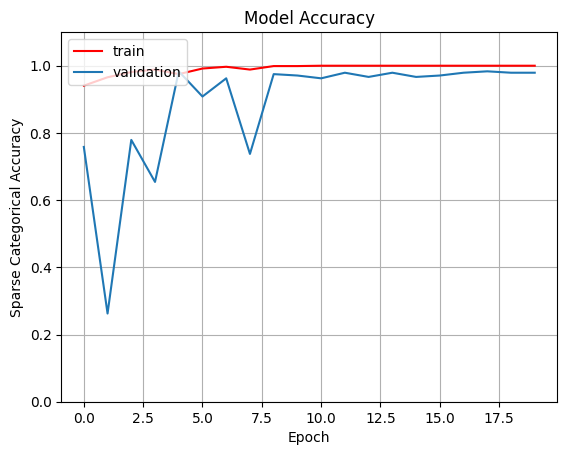

In [26]:
plot_hist_acc(historial)

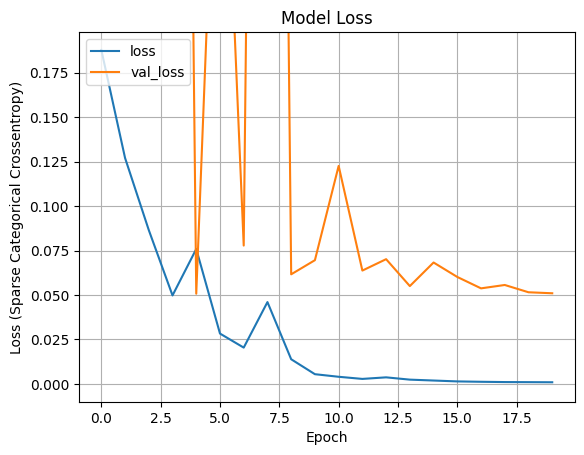

In [32]:
plot_hist_loss(historial)

In [28]:
test_data = test_ds.unbatch()
test_labels = []
for i, (imagen, etiqueta) in enumerate(test_data):
  test_labels.append(etiqueta.numpy())

In [29]:
test_pred = mejorModelo.predict(test_ds)

50/50 [==============================] - 0s 6ms/step


In [30]:
pred_test = np.zeros(len(test_labels))

for id in range(len(test_labels)):
    pred_test[id] = np.argmax( test_pred[id] )

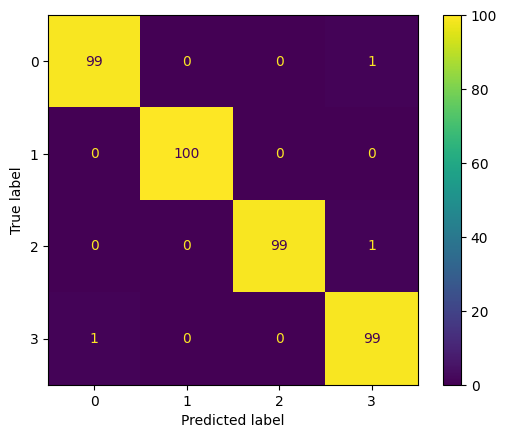

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

con = confusion_matrix( test_labels , pred_test )
disp = ConfusionMatrixDisplay( confusion_matrix = con ).plot()
plt.show()